In [ ]:
# --- Semana 1: Ejemplo de regresión lineal ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Datos ficticios: m2 de casas y precios
metros = np.array([50, 60, 80, 100, 120, 150, 200]).reshape(-1, 1)
precios = np.array([100, 120, 160, 200, 240, 300, 400])

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(metros, precios, test_size=0.2, random_state=42)

# Crear modelo
modelo = LinearRegression()

# Entrenar
modelo.fit(X_train, y_train)

# Predecir
predicciones = modelo.predict(X_test)

# Resultados
print("Coeficiente (pendiente):", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)
print("Predicciones:", predicciones)
print("Valores reales:", y_test)

# Visualización
plt.scatter(metros, precios, color="blue", label="Datos reales")
plt.plot(metros, modelo.predict(metros), color="red", label="Modelo")
plt.xlabel("Metros cuadrados")
plt.ylabel("Precio (miles)")
plt.legend()
plt.show()



=== Logística ===
Accuracy : 0.7612
Precision: 0.7535
Recall   : 0.7758
F1       : 0.7645
AUC      : 0.8282
Matriz de confusión:
[[934 317]
 [280 969]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7694    0.7466    0.7578      1251
           1     0.7535    0.7758    0.7645      1249

    accuracy                         0.7612      2500
   macro avg     0.7614    0.7612    0.7612      2500
weighted avg     0.7614    0.7612    0.7612      2500



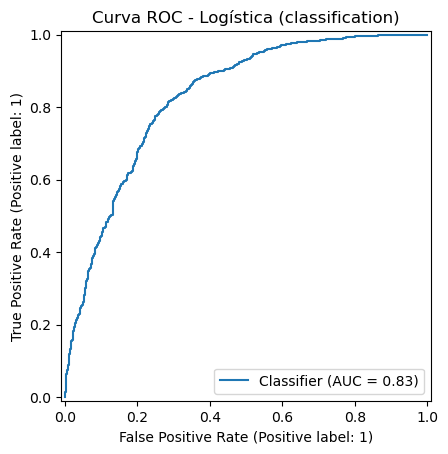


=== KNN ===
Accuracy : 0.8824
Precision: 0.8682
Recall   : 0.9015
F1       : 0.8845
AUC      : 0.9516
Matriz de confusión:
[[1080  171]
 [ 123 1126]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8978    0.8633    0.8802      1251
           1     0.8682    0.9015    0.8845      1249

    accuracy                         0.8824      2500
   macro avg     0.8830    0.8824    0.8824      2500
weighted avg     0.8830    0.8824    0.8824      2500



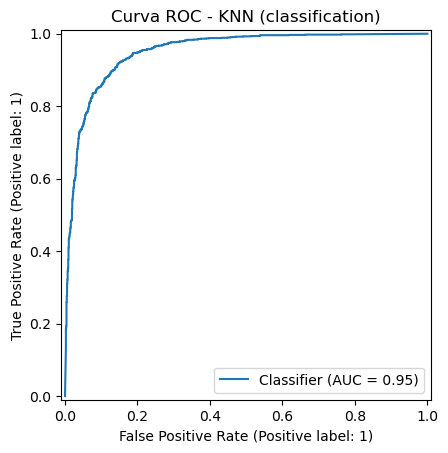


=== SVM-RBF ===
Accuracy : 0.9208
Precision: 0.9015
Recall   : 0.9448
F1       : 0.9226
AUC      : 0.9673
Matriz de confusión:
[[1122  129]
 [  69 1180]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9421    0.8969    0.9189      1251
           1     0.9015    0.9448    0.9226      1249

    accuracy                         0.9208      2500
   macro avg     0.9218    0.9208    0.9208      2500
weighted avg     0.9218    0.9208    0.9208      2500



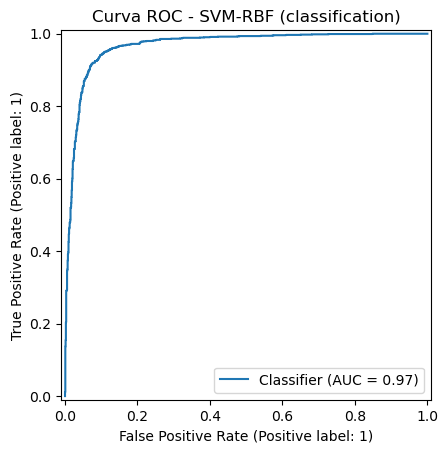


=== MLP ===
Accuracy : 0.9488
Precision: 0.9459
Recall   : 0.9520
F1       : 0.9489
AUC      : 0.9785
Matriz de confusión:
[[1183   68]
 [  60 1189]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9517    0.9456    0.9487      1251
           1     0.9459    0.9520    0.9489      1249

    accuracy                         0.9488      2500
   macro avg     0.9488    0.9488    0.9488      2500
weighted avg     0.9488    0.9488    0.9488      2500



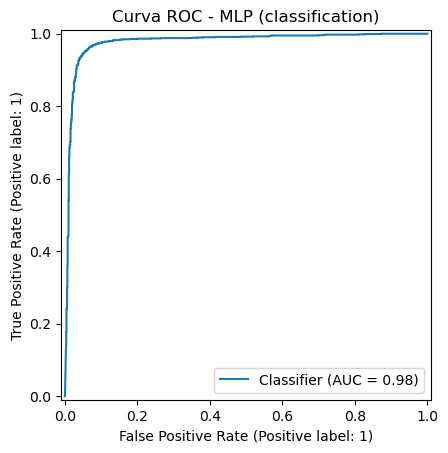


--- Resumen (Accuracy, F1, AUC) ---
Logística   Acc=0.7612  F1=0.7645  AUC=0.8282
KNN         Acc=0.8824  F1=0.8845  AUC=0.9516
SVM-RBF     Acc=0.9208  F1=0.9226  AUC=0.9673
MLP         Acc=0.9488  F1=0.9489  AUC=0.9785

=== Validación cruzada 5-fold (Accuracy) ===
Logística   mean=0.7587  +/- 0.0062
KNN         mean=0.8890  +/- 0.0063
SVM-RBF     mean=0.9194  +/- 0.0035
MLP         mean=0.9455  +/- 0.0029


In [6]:
# ==========================================
# Comparador de modelos clásicos + MLP en 3 datasets
# Datasets: "moons", "circles", "classification"
# Modelos: Regresión Logística, KNN, SVM-RBF, MLP
# Métricas: Accuracy, Precision, Recall, F1, AUC + CV 5-fold
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

# ---------- CONFIGURACIÓN ----------
RANDOM_STATE = 42
DATASET_CHOICE = "classification"         # <-- "moons" | "circles" | "classification"
TEST_SIZE = 0.25

# Dificultad de los datasets 2D
MOONS_NOISE = 0.35
CIRCLES_NOISE = 0.25
CIRCLES_FACTOR = 0.5  # separación entre círculos (0-1). Más bajo = más difícil

# Tamaño y dificultad del dataset tabular
CLASSIF_SAMPLES = 10000
CLASSIF_FEATURES = 20
CLASSIF_INFORMATIVE = 8
CLASSIF_REDUNDANT = 2
CLASSIF_CLUSTERS_PER_CLASS = 2
CLASSIF_CLASS_SEP = 1.2
CLASSIF_FLIP_Y = 0.02  # ruido de etiquetas

# ---------- CREACIÓN DEL DATASET ----------
if DATASET_CHOICE == "moons":
    X, y = make_moons(n_samples=10000, noise=MOONS_NOISE, random_state=RANDOM_STATE)
elif DATASET_CHOICE == "circles":
    X, y = make_circles(n_samples=10000, noise=CIRCLES_NOISE, factor=CIRCLES_FACTOR, random_state=RANDOM_STATE)
elif DATASET_CHOICE == "classification":
    X, y = make_classification(
        n_samples=CLASSIF_SAMPLES,
        n_features=CLASSIF_FEATURES,
        n_informative=CLASSIF_INFORMATIVE,
        n_redundant=CLASSIF_REDUNDANT,
        n_clusters_per_class=CLASSIF_CLUSTERS_PER_CLASS,
        class_sep=CLASSIF_CLASS_SEP,
        flip_y=CLASSIF_FLIP_Y,
        random_state=RANDOM_STATE
    )
else:
    raise ValueError("DATASET_CHOICE debe ser 'moons', 'circles' o 'classification'.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# ---------- MODELOS ----------
modelos = {
    "Logística": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance"))
    ]),
    "SVM-RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE))
    ]),
    "MLP": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64, 64),
                              activation="relu",
                              alpha=1e-4,
                              learning_rate_init=1e-2,
                              max_iter=400,
                              random_state=RANDOM_STATE))
    ]),
}

# ---------- EVALUACIÓN ----------
def eval_model(nombre, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Probabilidades para AUC
    if hasattr(modelo[-1], "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
    elif hasattr(modelo[-1], "decision_function"):
        scores = modelo.decision_function(X_test)
        # normalizar a [0,1] para AUC si no es proba
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {nombre} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    # Curva ROC (opcional si hay probas)
    if y_proba is not None and X.shape[1] > 0:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva ROC - {nombre} ({DATASET_CHOICE})")
        plt.show()

    return acc, f1, auc

resultados = {}
for nombre, modelo in modelos.items():
    resultados[nombre] = eval_model(nombre, modelo, X_train, y_train, X_test, y_test)

print("\n--- Resumen (Accuracy, F1, AUC) ---")
for k, (acc, f1, auc) in resultados.items():
    print(f"{k:10s}  Acc={acc:.4f}  F1={f1:.4f}  AUC={auc:.4f}")

# ---------- VALIDACIÓN CRUZADA ----------
print("\n=== Validación cruzada 5-fold (Accuracy) ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"{nombre:10s}  mean={scores.mean():.4f}  +/- {scores.std():.4f}")

# ---------- FRONTERA DE DECISIÓN (solo para 2D) ----------
def plot_decision_boundary(modelo, X, y, titulo):
    if X.shape[1] != 2:
        print("Plot omitido: dataset no es 2D.")
        return
    modelo.fit(X, y)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor="k", s=12)
    plt.title(titulo)
    plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
    plt.tight_layout(); plt.show()

if DATASET_CHOICE in ("moons", "circles"):
    for nombre, modelo in modelos.items():
        plot_decision_boundary(modelo, X, y, f"Frontera - {nombre} ({DATASET_CHOICE})")

